In [ ]:
import gymnasium as gym
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

from DQN_Agent import Agent as DQN_Agent
from SARSA_Agent import SARSA_Agent
from rl_utils import get_discrete_actions, get_action_size, ObservationNoiseWrapper


sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


RESULTS_DIR = "results/notebook_experiments"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:

SEEDS = [42, 1, 2, 3, 4] 
EPISODES = 1000     
MAX_STEPS = 1000

BASELINE_FILE = os.path.join(RESULTS_DIR, "baseline_results.csv")


## Helper Functions

In [ ]:
def make_env(continuous=True, enable_wind=False, wind_power=0.0, turbulence_power=0.0, noise_std=0.0, render_mode=None):
    env = gym.make(
        "LunarLander-v3",
        continuous=continuous,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power,
        render_mode=render_mode,
    )
    if noise_std > 0:
        env = ObservationNoiseWrapper(env, noise_std=noise_std)
    return env

def evaluate_agent(agent, agent_type, env, episodes=20, seed=42):
    total_rewards = []
    
    if agent_type in ["DQN", "SARSA"]:
        actions = get_discrete_actions(env)
        
    for i in range(episodes):
        state, _ = env.reset(seed=seed + i)
        episode_reward = 0
        done = False
        
        while not done:
            if agent_type in ["DQN", "SARSA"]:
                state_tensor = torch.from_numpy(state).float().unsqueeze(0)
                with torch.no_grad():
                    action_values = agent.local_qnetwork(state_tensor)
                action_idx = np.argmax(action_values.cpu().data.numpy())
                action = actions[action_idx].astype(np.float32)
            else: # PPO
                action, _ = agent.predict(state, deterministic=True)
            
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            
        total_rewards.append(episode_reward)
    return np.mean(total_rewards), np.std(total_rewards)

def save_intermediate_results(results_list, filename):
    df = pd.DataFrame(results_list)
    df.to_csv(filename, index=False)
    print(f"Saved {len(results_list)} rows to {filename}")

def load_trained_agents(seeds, results_dir):
    """
    Loads trained agents from disk if they exist.
    Returns a dictionary of agent_key -> agent_object.
    """
    loaded_agents = {}
    
    for seed in seeds:
        for algo in ["DQN", "SARSA"]:
            model_path = os.path.join(results_dir, f"{algo}_{seed}.pth")
            if os.path.exists(model_path):
                try:

                    env = make_env(continuous=True)
                    n_xvals = 2; n_yvals = 11
                    action_size = n_xvals * n_yvals
                    state_size = env.observation_space.shape[0]
                    
                    if algo == "DQN": 
                        agent = DQN_Agent(state_size, action_size)
                    else: 
                        agent = SARSA_Agent(state_size, action_size)
                        
                    agent.local_qnetwork.load_state_dict(torch.load(model_path))
                    loaded_agents[f"{algo}_{seed}"] = agent
                    print(f"Loaded {algo} Seed {seed} from {model_path}")
                except Exception as e:
                    print(f"Failed to load {algo} Seed {seed}: {e}")
    

    for seed in seeds:
        algo = "PPO"
        model_path = os.path.join(results_dir, f"{algo}_{seed}.zip")
        if os.path.exists(model_path):
            try:
                loaded_agents[f"{algo}_{seed}"] = PPO.load(model_path)
                print(f"Loaded {algo} Seed {seed} from {model_path}")
            except Exception as e:
                print(f"Failed to load {algo} Seed {seed}: {e}")
                
    return loaded_agents


def train_dqn_sarsa_notebook(agent_type, seed, env_params=None):
    if env_params is None: env_params = {}
    
    env = make_env(**env_params) if env_params else make_env(continuous=True)
    
    torch.manual_seed(seed)
    np.random.seed(seed)

    n_xvals = 2
    n_yvals = 11
    actions = get_discrete_actions(env, n_xvals, n_yvals)
    action_size = get_action_size(n_xvals, n_yvals)
    state_size = env.observation_space.shape[0]
    
    if agent_type == "DQN":
        agent = DQN_Agent(state_size, action_size)
    elif agent_type == "SARSA":
        agent = SARSA_Agent(state_size, action_size)
    else:
        raise ValueError(f"Unknown agent type: {agent_type}")
    
    scores = []
    epsilon_max = 1.0
    epsilon_min = 0.02
    epsilon_decay = 2e-3
    epsilon = epsilon_max
    
    for episode in range(EPISODES):
        state, _ = env.reset(seed=seed + episode)
        total_reward = 0
        done = False
        
        for t in range(MAX_STEPS):
            action_idx = agent.get_action(state, action_size, epsilon)
            action_continuous = actions[action_idx].astype(np.float32)
            
            next_state, reward, terminated, truncated, _ = env.step(action_continuous)
            done = terminated or truncated
            
            agent.step(state, action_idx, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            if done:
                break
        
        scores.append(total_reward)
        epsilon = epsilon_min + (epsilon_max - epsilon_min) * np.exp(-epsilon_decay * episode)
        
        if episode % 100 == 0:
            avg_score = np.mean(scores[-100:]) if len(scores) >= 100 else np.mean(scores)
            print(f"[{agent_type}] Seed {seed} | Ep {episode} | Avg Score: {avg_score:.2f} | Eps: {epsilon:.3f}")
            
    return agent, scores


## Experiment 1: Baseline Comparison
We train PPO, DQN, and SARSA in the nominal environment and compare their learning curves.

In [ ]:

if os.path.exists(BASELINE_FILE):
    baseline_results = pd.read_csv(BASELINE_FILE).to_dict('records')
    print(f"Loaded {len(baseline_results)} existing baseline results.")
else:
    baseline_results = []

trained_agents = {}

trained_agents.update(load_trained_agents(SEEDS, RESULTS_DIR))

for seed in SEEDS:
    for algo in ["DQN", "SARSA"]:
        results_exist = any(r['Algorithm'] == algo and r['Seed'] == seed for r in baseline_results)
        model_path = os.path.join(RESULTS_DIR, f"{algo}_{seed}.pth")
        model_exists = os.path.exists(model_path)
        
        if results_exist and model_exists:
            print(f"Skipping {algo} Seed {seed} (Already found in results and model file)")
            if f"{algo}_{seed}" not in trained_agents:
                env = make_env(continuous=True)
                n_xvals = 2; n_yvals = 11
                action_size = n_xvals * n_yvals
                state_size = env.observation_space.shape[0]
                if algo == "DQN": agent = DQN_Agent(state_size, action_size)
                else: agent = SARSA_Agent(state_size, action_size)
                agent.local_qnetwork.load_state_dict(torch.load(model_path))
                trained_agents[f"{algo}_{seed}"] = agent
            continue
        
        if results_exist and not model_exists:
             print(f"Results exist but model NOT found for {algo} Seed {seed}. Retraining to recover model...")
             baseline_results = [r for r in baseline_results if not (r['Algorithm'] == algo and r['Seed'] == seed)]
        
        print(f"Training {algo} Seed {seed}...")
        agent, scores = train_dqn_sarsa_notebook(algo, seed)
        trained_agents[f"{algo}_{seed}"] = agent
        
        torch.save(agent.local_qnetwork.state_dict(), os.path.join(RESULTS_DIR, f"{algo}_{seed}.pth"))
        
        for i, score in enumerate(scores):
            baseline_results.append({"Algorithm": algo, "Seed": seed, "Episode": i, "Reward": score})
        
        save_intermediate_results(baseline_results, BASELINE_FILE)
        gc.collect()

Training DQN Seed 42...


/Users/nakaji-m/anaconda3/envs/rl-lander/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


[DQN] Seed 42 | Ep 0 | Avg Score: -374.59 | Eps: 1.000
[DQN] Seed 42 | Ep 100 | Avg Score: -289.66 | Eps: 0.822
[DQN] Seed 42 | Ep 200 | Avg Score: -167.29 | Eps: 0.677
[DQN] Seed 42 | Ep 300 | Avg Score: -74.49 | Eps: 0.558
[DQN] Seed 42 | Ep 400 | Avg Score: -69.54 | Eps: 0.460
[DQN] Seed 42 | Ep 500 | Avg Score: -101.00 | Eps: 0.381
[DQN] Seed 42 | Ep 600 | Avg Score: -94.76 | Eps: 0.315
[DQN] Seed 42 | Ep 700 | Avg Score: -80.36 | Eps: 0.262
[DQN] Seed 42 | Ep 800 | Avg Score: -72.70 | Eps: 0.218
[DQN] Seed 42 | Ep 900 | Avg Score: -87.18 | Eps: 0.182
Saved 1000 rows to results/notebook_experiments/baseline_results.csv
Training SARSA Seed 42...
[SARSA] Seed 42 | Ep 0 | Avg Score: -374.59 | Eps: 1.000
[SARSA] Seed 42 | Ep 100 | Avg Score: -283.57 | Eps: 0.822
[SARSA] Seed 42 | Ep 200 | Avg Score: -162.50 | Eps: 0.677
[SARSA] Seed 42 | Ep 300 | Avg Score: -99.83 | Eps: 0.558
[SARSA] Seed 42 | Ep 400 | Avg Score: -58.64 | Eps: 0.460
[SARSA] Seed 42 | Ep 500 | Avg Score: -101.92 | Eps:

In [ ]:
algo = "PPO"

trained_agents.update(load_trained_agents(SEEDS, RESULTS_DIR))

for seed in SEEDS:
    results_exist = any(r['Algorithm'] == algo and r['Seed'] == seed for r in baseline_results)
    model_path = os.path.join(RESULTS_DIR, f"{algo}_{seed}.zip")
    model_exists = os.path.exists(model_path)

    if results_exist and model_exists:
        print(f"Skipping {algo} Seed {seed} (Already found in results and model file)")
        if f"{algo}_{seed}" not in trained_agents:
             trained_agents[f"{algo}_{seed}"] = PPO.load(model_path)
        continue
    
    if results_exist and not model_exists:
         print(f"Results exist but model NOT found for {algo} Seed {seed}. Retraining...")
         baseline_results = [r for r in baseline_results if not (r['Algorithm'] == algo and r['Seed'] == seed)]

    print(f"Training {algo} Seed {seed}...")
    from stable_baselines3.common.monitor import Monitor
    
    monitored_env = Monitor(make_env(continuous=True))
    env = DummyVecEnv([lambda: monitored_env])
    model = PPO("MlpPolicy", env, verbose=0, seed=seed)
    
    model.learn(total_timesteps=EPISODES * 300) 
    trained_agents[f"{algo}_{seed}"] = model
    model.save(os.path.join(RESULTS_DIR, f"{algo}_{seed}"))

    rewards = monitored_env.get_episode_rewards()
    for i, score in enumerate(rewards):
        if i < EPISODES:
            baseline_results.append({"Algorithm": algo, "Seed": seed, "Episode": i, "Reward": score})
            
    save_intermediate_results(baseline_results, BASELINE_FILE)
    gc.collect()

Loaded DQN Seed 42 from results/notebook_experiments/DQN_42.pth
Loaded SARSA Seed 42 from results/notebook_experiments/SARSA_42.pth
Loaded DQN Seed 1 from results/notebook_experiments/DQN_1.pth
Loaded SARSA Seed 1 from results/notebook_experiments/SARSA_1.pth
Loaded DQN Seed 2 from results/notebook_experiments/DQN_2.pth
Loaded SARSA Seed 2 from results/notebook_experiments/SARSA_2.pth
Loaded DQN Seed 3 from results/notebook_experiments/DQN_3.pth
Loaded SARSA Seed 3 from results/notebook_experiments/SARSA_3.pth
Loaded DQN Seed 4 from results/notebook_experiments/DQN_4.pth
Loaded SARSA Seed 4 from results/notebook_experiments/SARSA_4.pth
Training PPO Seed 42...
Saved 10561 rows to results/notebook_experiments/baseline_results.csv
Training PPO Seed 1...
Saved 11151 rows to results/notebook_experiments/baseline_results.csv
Training PPO Seed 2...
Saved 11705 rows to results/notebook_experiments/baseline_results.csv
Training PPO Seed 3...
Saved 12300 rows to results/notebook_experiments/base

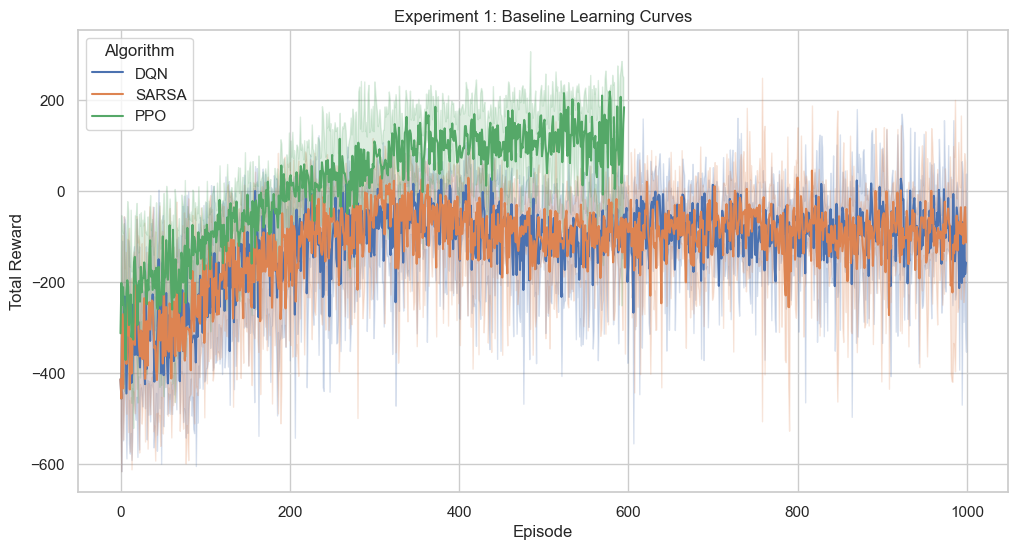

In [ ]:
df_baseline = pd.DataFrame(baseline_results)
if not df_baseline.empty:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_baseline, x="Episode", y="Reward", hue="Algorithm", errorbar="sd")
    plt.title("Experiment 1: Baseline Learning Curves")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.savefig(os.path.join(RESULTS_DIR, "baseline_learning_curve.png"))
    plt.show()
else:
    print("No baseline results to plot.")

## Experiment 2: Robustness to Environment Noise
We evaluate the trained agents under increasing wind and turbulence.

In [ ]:
try:
    trained_agents
except NameError:
    trained_agents = {}

if not trained_agents:
    print("Loading trained agents from disk...")
    trained_agents = load_trained_agents(SEEDS, RESULTS_DIR)

env_noise_levels = [
    {"label": "None", "wind": 0.0, "turb": 0.0},
    {"label": "Low", "wind": 5.0, "turb": 0.5},
    {"label": "Medium", "wind": 10.0, "turb": 1.0},
    {"label": "High", "wind": 15.0, "turb": 1.5},
    {"label": "Extreme", "wind": 20.0, "turb": 2.0},
]

ROBUSTNESS_FILE = os.path.join(RESULTS_DIR, "env_robustness_results.csv")

if os.path.exists(ROBUSTNESS_FILE):
    robustness_results = pd.read_csv(ROBUSTNESS_FILE).to_dict('records')
    print(f"Loaded {len(robustness_results)} existing robustness results.")
else:
    robustness_results = []

for seed in SEEDS:
    for algo in ["DQN", "SARSA", "PPO"]:
        agent_key = f"{algo}_{seed}"
        if agent_key not in trained_agents:
            print(f"Agent {agent_key} not found in memory. Ensure baseline is run or models are loaded.")
            continue
        agent = trained_agents[agent_key]
        
        for level in env_noise_levels:
            # Check if done
            if any(r['Algorithm'] == algo and r['Seed'] == seed and r['Noise Level'] == level['label'] for r in robustness_results):
                continue
                
            env = make_env(continuous=True, enable_wind=True, wind_power=level["wind"], turbulence_power=level["turb"])
            mean_reward, std_reward = evaluate_agent(agent, algo, env, episodes=10, seed=seed)
            
            robustness_results.append({
                "Algorithm": algo,
                "Seed": seed,
                "Noise Level": level["label"],
                "Wind Power": level["wind"],
                "Mean Reward": mean_reward
            })
            
        # Save after each agent
        save_intermediate_results(robustness_results, ROBUSTNESS_FILE)

Saved 5 rows to results/notebook_experiments/env_robustness_results.csv
Saved 10 rows to results/notebook_experiments/env_robustness_results.csv
Saved 15 rows to results/notebook_experiments/env_robustness_results.csv
Saved 20 rows to results/notebook_experiments/env_robustness_results.csv
Saved 25 rows to results/notebook_experiments/env_robustness_results.csv
Saved 30 rows to results/notebook_experiments/env_robustness_results.csv
Saved 35 rows to results/notebook_experiments/env_robustness_results.csv
Saved 40 rows to results/notebook_experiments/env_robustness_results.csv
Saved 45 rows to results/notebook_experiments/env_robustness_results.csv
Saved 50 rows to results/notebook_experiments/env_robustness_results.csv
Saved 55 rows to results/notebook_experiments/env_robustness_results.csv
Saved 60 rows to results/notebook_experiments/env_robustness_results.csv
Saved 65 rows to results/notebook_experiments/env_robustness_results.csv
Saved 70 rows to results/notebook_experiments/env_ro

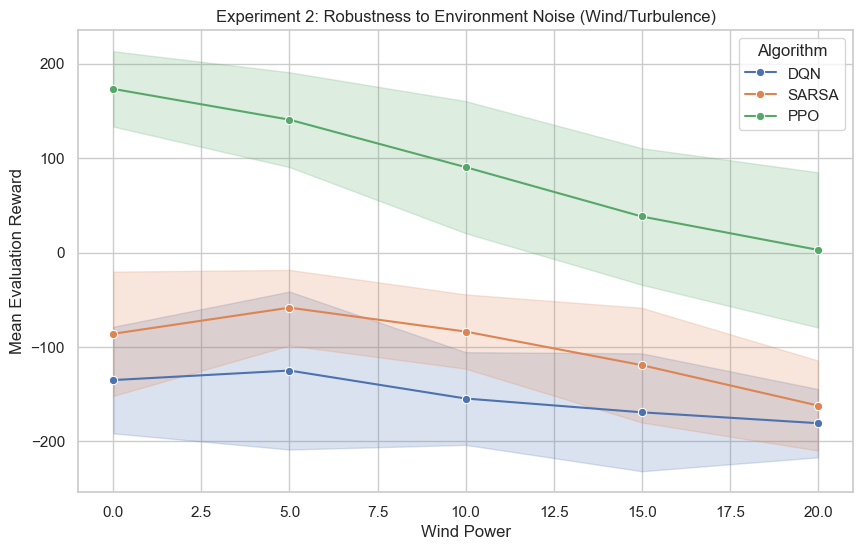

In [8]:
# Plot Environment Robustness
df_robust = pd.DataFrame(robustness_results)
if not df_robust.empty:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_robust, x="Wind Power", y="Mean Reward", hue="Algorithm", marker="o", errorbar="sd")
    plt.title("Experiment 2: Robustness to Environment Noise (Wind/Turbulence)")
    plt.xlabel("Wind Power")
    plt.ylabel("Mean Evaluation Reward")
    plt.savefig(os.path.join(RESULTS_DIR, "env_robustness.png"))
    plt.show()

## Experiment 3: Robustness to Observation Noise
We evaluate the trained agents under increasing sensor noise (Gaussian noise added to observations).

In [9]:
obs_noise_levels = [0.0, 0.05, 0.1, 0.2, 0.3, 0.5]

OBS_ROBUSTNESS_FILE = os.path.join(RESULTS_DIR, "obs_robustness_results.csv")

if os.path.exists(OBS_ROBUSTNESS_FILE):
    obs_robustness_results = pd.read_csv(OBS_ROBUSTNESS_FILE).to_dict('records')
    print(f"Loaded {len(obs_robustness_results)} existing observation robustness results.")
else:
    obs_robustness_results = []

for seed in SEEDS:
    for algo in ["DQN", "SARSA", "PPO"]:
        agent_key = f"{algo}_{seed}"
        if agent_key not in trained_agents:
            continue
        agent = trained_agents[agent_key]
        
        for noise in obs_noise_levels:
            if any(r['Algorithm'] == algo and r['Seed'] == seed and r['Noise Std'] == noise for r in obs_robustness_results):
                continue

            env = make_env(continuous=True, noise_std=noise)
            mean_reward, std_reward = evaluate_agent(agent, algo, env, episodes=10, seed=seed)
            
            obs_robustness_results.append({
                "Algorithm": algo,
                "Seed": seed,
                "Noise Std": noise,
                "Mean Reward": mean_reward
            })
            
        save_intermediate_results(obs_robustness_results, OBS_ROBUSTNESS_FILE)

Saved 6 rows to results/notebook_experiments/obs_robustness_results.csv
Saved 12 rows to results/notebook_experiments/obs_robustness_results.csv
Saved 18 rows to results/notebook_experiments/obs_robustness_results.csv
Saved 24 rows to results/notebook_experiments/obs_robustness_results.csv
Saved 30 rows to results/notebook_experiments/obs_robustness_results.csv
Saved 36 rows to results/notebook_experiments/obs_robustness_results.csv
Saved 42 rows to results/notebook_experiments/obs_robustness_results.csv
Saved 48 rows to results/notebook_experiments/obs_robustness_results.csv
Saved 54 rows to results/notebook_experiments/obs_robustness_results.csv
Saved 60 rows to results/notebook_experiments/obs_robustness_results.csv
Saved 66 rows to results/notebook_experiments/obs_robustness_results.csv
Saved 72 rows to results/notebook_experiments/obs_robustness_results.csv
Saved 78 rows to results/notebook_experiments/obs_robustness_results.csv
Saved 84 rows to results/notebook_experiments/obs_ro

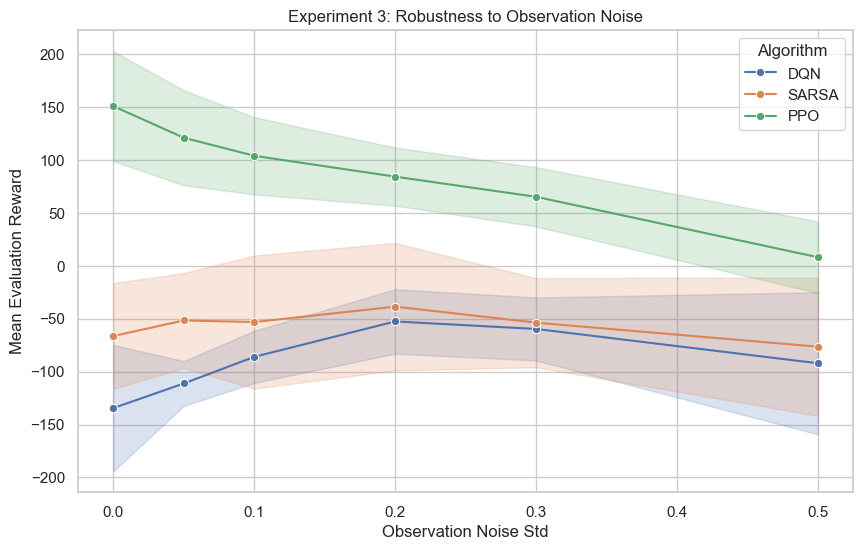

In [10]:
# Plot Observation Robustness
df_obs_robust = pd.DataFrame(obs_robustness_results)
if not df_obs_robust.empty:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_obs_robust, x="Noise Std", y="Mean Reward", hue="Algorithm", marker="o", errorbar="sd")
    plt.title("Experiment 3: Robustness to Observation Noise")
    plt.xlabel("Observation Noise Std")
    plt.ylabel("Mean Evaluation Reward")
    plt.savefig(os.path.join(RESULTS_DIR, "obs_robustness.png"))
    plt.show()

## Experiment 4: Robust Training
We train agents in a noisy environment (Medium Wind) and compare their robustness against the baseline agents.

In [ ]:
ROBUST_TRAIN_PARAMS = {"enable_wind": True, "wind_power": 10.0, "turbulence_power": 1.0}
ROBUST_TRAIN_FILE = os.path.join(RESULTS_DIR, "robust_training_results.csv")

if os.path.exists(ROBUST_TRAIN_FILE):
    robust_training_results = pd.read_csv(ROBUST_TRAIN_FILE).to_dict('records')
    print(f"Loaded {len(robust_training_results)} existing robust training results.")
else:
    robust_training_results = []

robust_agents = {}

for seed in SEEDS:
    for algo in ["DQN", "SARSA"]:
        robust_algo_name = f"{algo}_Robust"
        
        if any(r['Algorithm'] == robust_algo_name and r['Seed'] == seed for r in robust_training_results):
             print(f"Skipping {robust_algo_name} Seed {seed} (Already found in results)")
             model_path = os.path.join(RESULTS_DIR, f"{robust_algo_name}_{seed}.pth")
             if os.path.exists(model_path):
                env = make_env(continuous=True)
                n_xvals = 2; n_yvals = 11
                action_size = n_xvals * n_yvals
                state_size = env.observation_space.shape[0]
                if algo == "DQN": agent = DQN_Agent(state_size, action_size)
                else: agent = SARSA_Agent(state_size, action_size)
                agent.local_qnetwork.load_state_dict(torch.load(model_path))
                robust_agents[f"{robust_algo_name}_{seed}"] = agent
                continue
        
        print(f"Training {robust_algo_name} Seed {seed}...")
        agent, scores = train_dqn_sarsa_notebook(algo, seed, env_params=ROBUST_TRAIN_PARAMS)
        robust_agents[f"{robust_algo_name}_{seed}"] = agent
        
        torch.save(agent.local_qnetwork.state_dict(), os.path.join(RESULTS_DIR, f"{robust_algo_name}_{seed}.pth"))
        
        for i, score in enumerate(scores):
            robust_training_results.append({"Algorithm": robust_algo_name, "Seed": seed, "Episode": i, "Reward": score})
        
        save_intermediate_results(robust_training_results, ROBUST_TRAIN_FILE)
        gc.collect()

algo = "PPO"
robust_algo_name = "PPO_Robust"
for seed in SEEDS:
    if any(r['Algorithm'] == robust_algo_name and r['Seed'] == seed for r in robust_training_results):
        print(f"Skipping {robust_algo_name} Seed {seed} (Already found in results)")
        model_path = os.path.join(RESULTS_DIR, f"{robust_algo_name}_{seed}.zip")
        if os.path.exists(model_path):
            robust_agents[f"{robust_algo_name}_{seed}"] = PPO.load(model_path)
            continue

    print(f"Training {robust_algo_name} Seed {seed}...")
    from stable_baselines3.common.monitor import Monitor
    
    monitored_env = Monitor(make_env(continuous=True, **ROBUST_TRAIN_PARAMS))
    env = DummyVecEnv([lambda: monitored_env])
    model = PPO("MlpPolicy", env, verbose=0, seed=seed)
    
    model.learn(total_timesteps=EPISODES * 300)
    robust_agents[f"{robust_algo_name}_{seed}"] = model
    model.save(os.path.join(RESULTS_DIR, f"{robust_algo_name}_{seed}"))
    
    rewards = monitored_env.get_episode_rewards()
    for i, score in enumerate(rewards):
        if i < EPISODES:
            robust_training_results.append({"Algorithm": robust_algo_name, "Seed": seed, "Episode": i, "Reward": score})
            
    save_intermediate_results(robust_training_results, ROBUST_TRAIN_FILE)
    gc.collect()

Training DQN_Robust Seed 42...
[DQN] Seed 42 | Ep 0 | Avg Score: -532.29 | Eps: 1.000
[DQN] Seed 42 | Ep 100 | Avg Score: -353.19 | Eps: 0.822
[DQN] Seed 42 | Ep 200 | Avg Score: -259.24 | Eps: 0.677
[DQN] Seed 42 | Ep 300 | Avg Score: -137.17 | Eps: 0.558
[DQN] Seed 42 | Ep 400 | Avg Score: -76.75 | Eps: 0.460
[DQN] Seed 42 | Ep 500 | Avg Score: -59.63 | Eps: 0.381
[DQN] Seed 42 | Ep 600 | Avg Score: -51.75 | Eps: 0.315
[DQN] Seed 42 | Ep 700 | Avg Score: -29.69 | Eps: 0.262
[DQN] Seed 42 | Ep 800 | Avg Score: -26.44 | Eps: 0.218
[DQN] Seed 42 | Ep 900 | Avg Score: 4.10 | Eps: 0.182
Saved 1000 rows to results/notebook_experiments/robust_training_results.csv
Training SARSA_Robust Seed 42...
[SARSA] Seed 42 | Ep 0 | Avg Score: -532.29 | Eps: 1.000
[SARSA] Seed 42 | Ep 100 | Avg Score: -349.47 | Eps: 0.822
[SARSA] Seed 42 | Ep 200 | Avg Score: -240.96 | Eps: 0.677
[SARSA] Seed 42 | Ep 300 | Avg Score: -149.50 | Eps: 0.558
[SARSA] Seed 42 | Ep 400 | Avg Score: -99.38 | Eps: 0.460
[SARSA] 

In [ ]:
comparison_results = []
COMPARISON_FILE = os.path.join(RESULTS_DIR, "robust_comparison_results.csv")

if os.path.exists(COMPARISON_FILE):
    comparison_results = pd.read_csv(COMPARISON_FILE).to_dict('records')

all_agents = {**trained_agents, **robust_agents}

for seed in SEEDS:
    for algo_base in ["DQN", "SARSA", "PPO"]:
        for variant in ["", "_Robust"]:
            algo_name = f"{algo_base}{variant}"
            agent_key = f"{algo_name}_{seed}"
            
            if agent_key not in all_agents:
                continue
            
            agent = all_agents[agent_key]
            
            for level in env_noise_levels:
                 if any(r['Algorithm'] == algo_name and r['Seed'] == seed and r['Noise Level'] == level['label'] for r in comparison_results):
                    continue
                
                 env = make_env(continuous=True, enable_wind=True, wind_power=level["wind"], turbulence_power=level["turb"])
                 mean_reward, std_reward = evaluate_agent(agent, algo_base, env, episodes=10, seed=seed)
                 
                 comparison_results.append({
                    "Algorithm": algo_name,
                    "Base Algo": algo_base,
                    "Training": "Robust" if variant else "Baseline",
                    "Seed": seed,
                    "Noise Level": level["label"],
                    "Wind Power": level["wind"],
                    "Mean Reward": mean_reward
                 })
            
            save_intermediate_results(comparison_results, COMPARISON_FILE)

Saved 5 rows to results/notebook_experiments/robust_comparison_results.csv
Saved 10 rows to results/notebook_experiments/robust_comparison_results.csv
Saved 15 rows to results/notebook_experiments/robust_comparison_results.csv
Saved 20 rows to results/notebook_experiments/robust_comparison_results.csv
Saved 25 rows to results/notebook_experiments/robust_comparison_results.csv
Saved 30 rows to results/notebook_experiments/robust_comparison_results.csv
Saved 35 rows to results/notebook_experiments/robust_comparison_results.csv
Saved 40 rows to results/notebook_experiments/robust_comparison_results.csv
Saved 45 rows to results/notebook_experiments/robust_comparison_results.csv
Saved 50 rows to results/notebook_experiments/robust_comparison_results.csv
Saved 55 rows to results/notebook_experiments/robust_comparison_results.csv
Saved 60 rows to results/notebook_experiments/robust_comparison_results.csv
Saved 65 rows to results/notebook_experiments/robust_comparison_results.csv
Saved 70 rows

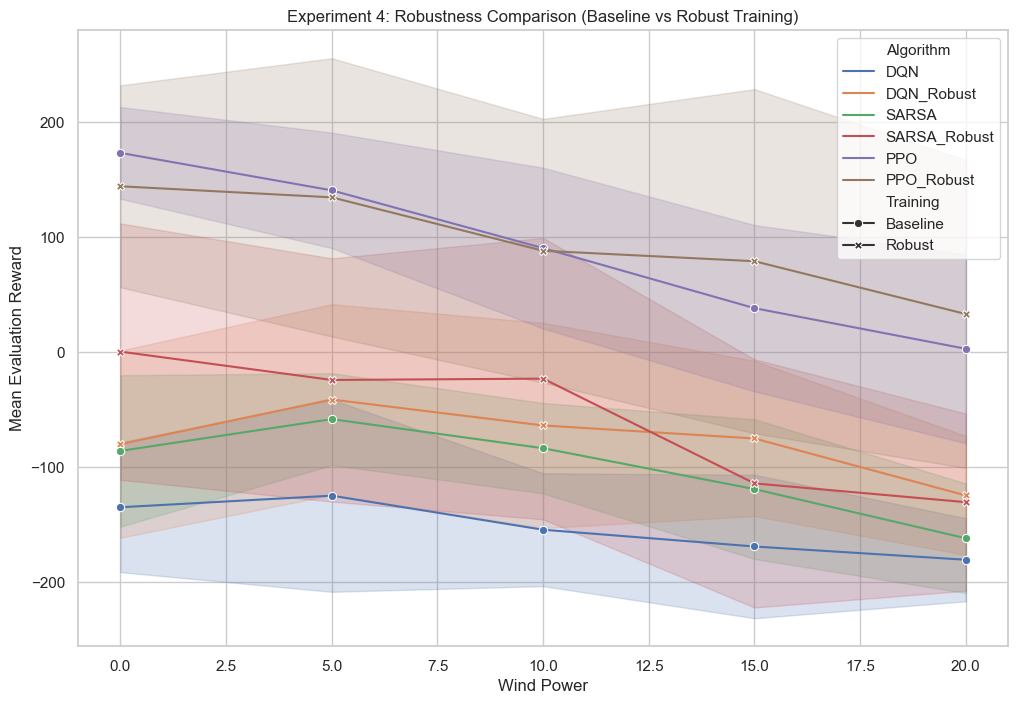

In [ ]:
df_comp = pd.DataFrame(comparison_results)
if not df_comp.empty:
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_comp, x="Wind Power", y="Mean Reward", hue="Algorithm", style="Training", markers=True, dashes=False, errorbar="sd")
    plt.title("Experiment 4: Robustness Comparison (Baseline vs Robust Training)")
    plt.xlabel("Wind Power")
    plt.ylabel("Mean Evaluation Reward")
    plt.savefig(os.path.join(RESULTS_DIR, "robust_comparison.png"))
    plt.show()